# Bias Detection in Credit Approvals

This project identified and quantified significant biases in a credit approval model, revealing critical disparities across gender and age groups. Through rigorous analysis, we determined that while the model achieves 74% accuracy, it systematically under-approves qualified applicants (particularly young adults and women) and exhibits alarmingly high false denial rates (67-81%).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Data Preprocessing

This includes handles missing values and creates new features:

- Age bins (18-25, 26-35, 36-50, 51+)
- Gender extraction from PersonalStatusSex (codes 2/3/5 = Female)
- Financial ratios (DebtToIncome, InstallmentBurden)

In [2]:
class CreditDataPreprocessor:
    """Handles all data loading and preprocessing operations"""

    def __init__(self, data_path="german_credit_data.csv"):
        # Load data with correct column names
        self.df = pd.read_csv(data_path)

        self.column_map = {
            'laufkont': 'Status',
            'laufzeit': 'Duration',
            'moral': 'CreditHistory',
            'verw': 'Purpose',
            'hoehe': 'Amount',
            'sparkont': 'Savings',
            'beszeit': 'EmploymentDuration',
            'rate': 'InstallmentRate',
            'famges': 'PersonalStatusSex',
            'buerge': 'OtherDebtors',
            'wohnzeit': 'ResidenceDuration',
            'verm': 'Property',
            'alter': 'Age',
            'weitkred': 'OtherInstallments',
            'wohn': 'Housing',
            'bishkred': 'NumCredits',
            'beruf': 'Job',
            'pers': 'Dependents',
            'telef': 'Telephone',
            'gastarb': 'ForeignWorker',
            'kredit': 'Default'
        }
        self.df.rename(columns=self.column_map, inplace=True)

        # DEBUG: Print the actual columns after renaming
        print("Columns AFTER renaming:", self.df.columns.tolist())

        self._preprocess_data()
        self._train_test_split()

    def load_data(self, filepath):
        """Load and validate credit data"""
        df = pd.read_csv(filepath)

        # Rename columns using mapping
        df = df.rename(columns={k: v for k, v in self.column_map.items() if k in df.columns})

        # Validate required columns
        required_columns = ['Duration', 'Amount', 'Age', 'Default']
        missing = [col for col in required_columns if col not in df.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        return df

    def _preprocess_data(self):
        """Handle missing values and feature engineering"""
        self.df = self.df.dropna()

        # Create age bins
        self.df['Age_binned'] = pd.cut(
            self.df['Age'],
            bins=[18, 25, 35, 50, 100],
            labels=['18-25', '26-35', '36-50', '51+']
        )

        # Extract gender from PersonalStatusSex
        if 'PersonalStatusSex' in self.df.columns:
            # Different codes might be used - adjust based on your data
            # This is a common encoding in German credit data
            self.df['Gender'] = self.df['PersonalStatusSex'].astype(str).apply(
                lambda x: 'Female' if x in ['2', '3', '5'] else 'Male'
            )
        else:
            raise KeyError("'PersonalStatusSex' column not found. Available columns: " +
                           str(self.df.columns.tolist()))
        
        # Add financial features
        self.df = self._add_financial_features(self.df)
        
        # Store feature statistics
        self._store_feature_stats(self.df.select_dtypes(include=['number']))

    def _train_test_split(self):
        """Perform and store train-test split"""
        self.X = self.df.drop('Default', axis=1)
        self.y = self.df['Default']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )

    def _add_financial_features(self, df):
        """Create financial ratios and risk indicators"""
        df = df.copy()

        # Liquidity ratios
        df['DebtToIncome'] = df['Amount'] / (df['Duration'] + 1e-6)
        df['InstallmentBurden'] = df['InstallmentRate'] / (df['Amount'] + 1e-6)

        # Stability indicators
        df['AgeSquared'] = df['Age'] ** 2
        df['LogAmount'] = np.log(df['Amount'] + 1)

        return df

    def _store_feature_stats(self, df):
        """Store descriptive statistics for features"""
        self.feature_stats_ = {
            'mean': df.mean(),
            'std': df.std(),
            'min': df.min(),
            'max': df.max()
        }
        
    def get_encoded_features(self, feature_list=None):
        """Get one-hot encoded features for model training"""
        if feature_list is None:
            feature_list = ['Amount', 'Age', 'Gender', 'Duration', 'InstallmentRate']
            
        # Filter to only include features that exist
        features = [f for f in feature_list if f in self.X_train.columns]
        
        # Get categorical and numerical features
        cat_features = [f for f in features if self.X_train[f].dtype == 'object' or self.X_train[f].dtype.name == 'category']
        num_features = [f for f in features if f not in cat_features]
        
        # Create encoded dataframe
        encoded_df = pd.get_dummies(self.X_train[cat_features], drop_first=True)
        
        # Add numerical features
        for feat in num_features:
            encoded_df[feat] = self.X_train[feat]
            
        return encoded_df

## Bias Detection

**Core Analysis:**

1. Protected Attributes: Focuses on Gender and Age_binned

2. Metrics Calculated:
- Approval Rate: % of applicants approved (1 - Default rate)
- Prediction Rate: % predicted as "approved" by the model

In [3]:
class BiasDetector:
    def __init__(self, preprocessor):
        # Create analysis dataframe with proper columns
        self.analysis_df = preprocessor.X_train.copy()
        self.analysis_df['CreditRisk'] = preprocessor.y_train  # Use renamed target
        
        # Verify protected attributes exist
        self.protected_attributes = []
        for attr in ['Gender', 'Age_binned']:
            if attr in self.analysis_df.columns:
                self.protected_attributes.append(attr)
        
        if not self.protected_attributes:
            raise ValueError(
                "No valid protected attributes found. Available columns:\n" +
                str(self.analysis_df.columns.tolist())
            )
            
        self.results = {}

    def predict_and_analyze(self, model, X_encoded):
        """Add predictions and analyze bias"""
        self.analysis_df['Predicted'] = model.predict(X_encoded)
        
        # Calculate overall metrics
        tn, fp, fn, tp = confusion_matrix(
            self.analysis_df['CreditRisk'],
            self.analysis_df['Predicted']
        ).ravel()
        
        self.overall_metrics = {
            'Approval Rate': 1 - self.analysis_df['CreditRisk'].mean(),
            'Prediction Rate': 1 - self.analysis_df['Predicted'].mean(),
            'FPR': fp / (fp + tn + 1e-6),
            'FNR': fn / (fn + tp + 1e-6),
            'Count': len(self.analysis_df)
        }
        
        # Analyze each protected group
        for attr in self.protected_attributes:
            self.analyze_protected_attribute(attr)
            
        return self.results
    
    def analyze_protected_attribute(self, attr):
        """Analyze bias for a specific attribute"""
        group_metrics = {}
        
        for group in self.analysis_df[attr].unique():
            mask = self.analysis_df[attr] == group
            group_data = self.analysis_df[mask]
            
            if len(group_data) < 5:  # Skip groups with too few samples
                continue
                
            true_labels = group_data['CreditRisk']
            predictions = group_data['Predicted']
                
            tn, fp, fn, tp = confusion_matrix(
                true_labels, 
                predictions
            ).ravel()
            
            # Calculate metrics
            group_metrics[group] = {
                'Approval Rate': 1 - true_labels.mean(),
                'Prediction Rate': 1 - predictions.mean(),
                'FPR': fp / (fp + tn + 1e-6),  # False Positive Rate
                'FNR': fn / (fn + tp + 1e-6),  # False Negative Rate
                'Count': len(group_data)
            }
        
        self.results[attr] = group_metrics
        
    def plot_bias_results(self, figsize=(16, 6)):
        """Plot bias analysis results for all attributes"""
        for attr, metrics in self.results.items():
            self._plot_attribute_results(attr, metrics, figsize)
            
    def _plot_attribute_results(self, attr, metrics, figsize=(16, 6)):
        """Plot results for a specific attribute"""
        metrics_df = pd.DataFrame(metrics).T
        
        # Add disparity metrics relative to overall
        overall_approval = self.overall_metrics['Approval Rate']
        overall_prediction = self.overall_metrics['Prediction Rate']
        
        metrics_df['Approval Disparity'] = metrics_df['Approval Rate'] - overall_approval
        metrics_df['Prediction Disparity'] = metrics_df['Prediction Rate'] - overall_prediction
        
        # Create figure with subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        
        # Approval and prediction rates
        metrics_df[['Approval Rate', 'Prediction Rate']].plot(
            kind='bar', ax=ax1,
            title=f'Approval Rates by {attr}',
            color=['teal', 'coral'], ylim=(0, 1)
        )
        ax1.axhline(y=overall_approval, color='navy', linestyle='--', label='Overall Approval')
        ax1.legend()
        
        # Error rates
        metrics_df[['FPR', 'FNR']].plot(
            kind='bar', ax=ax2,
            title=f'Error Rates by {attr}',
            color=['salmon', 'skyblue'], ylim=(0, 0.5)
        )
        ax2.set_ylabel('Rate')
        ax2.legend(['False Positive Rate', 'False Negative Rate'])
        
        # Disparity metrics
        metrics_df[['Approval Disparity', 'Prediction Disparity']].plot(
            kind='bar', ax=ax3,
            title=f'Disparity Metrics by {attr}',
            color=['darkgreen', 'darkred']
        )
        ax3.axhline(y=0, color='black', linestyle='-')
        ax3.set_ylabel('Disparity (+ is higher than avg)')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistical summary
        print(f"\n=== BIAS ANALYSIS FOR {attr} ===")
        print(metrics_df.round(3))
        
    def calculate_statistical_parity(self):
        """Calculate statistical parity differences between groups"""
        parity_results = {}
        
        for attr in self.protected_attributes:
            metrics = self.results[attr]
            groups = list(metrics.keys())
            
            if len(groups) < 2:
                continue
                
            # Get reference group (usually privileged)
            ref_group = groups[0]
            
            # Calculate disparities against reference
            disparities = {}
            for group in groups[1:]:
                stat_parity = metrics[group]['Prediction Rate'] - metrics[ref_group]['Prediction Rate']
                disparities[f"{ref_group} vs {group}"] = {
                    'Statistical Parity Difference': stat_parity,
                    'Approval Rate Ratio': metrics[group]['Approval Rate'] / metrics[ref_group]['Approval Rate'],
                    'Error Rate Ratio': metrics[group]['FPR'] / metrics[ref_group]['FPR']
                }
                
            parity_results[attr] = disparities
            
        # Display results
        for attr, disparities in parity_results.items():
            print(f"\n=== STATISTICAL PARITY FOR {attr} ===")
            print(pd.DataFrame(disparities).T.round(3))
            
        return parity_results


Loading and preprocessing data...
Columns AFTER renaming: ['Status', 'Duration', 'CreditHistory', 'Purpose', 'Amount', 'Savings', 'EmploymentDuration', 'InstallmentRate', 'PersonalStatusSex', 'OtherDebtors', 'ResidenceDuration', 'Property', 'Age', 'OtherInstallments', 'Housing', 'NumCredits', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'Default']
Data loaded with 1000 records
Training model with 8 features

=== MODEL PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.65      0.27      0.38       240
           1       0.75      0.94      0.83       560

    accuracy                           0.74       800
   macro avg       0.70      0.60      0.61       800
weighted avg       0.72      0.74      0.70       800


Performing bias analysis...


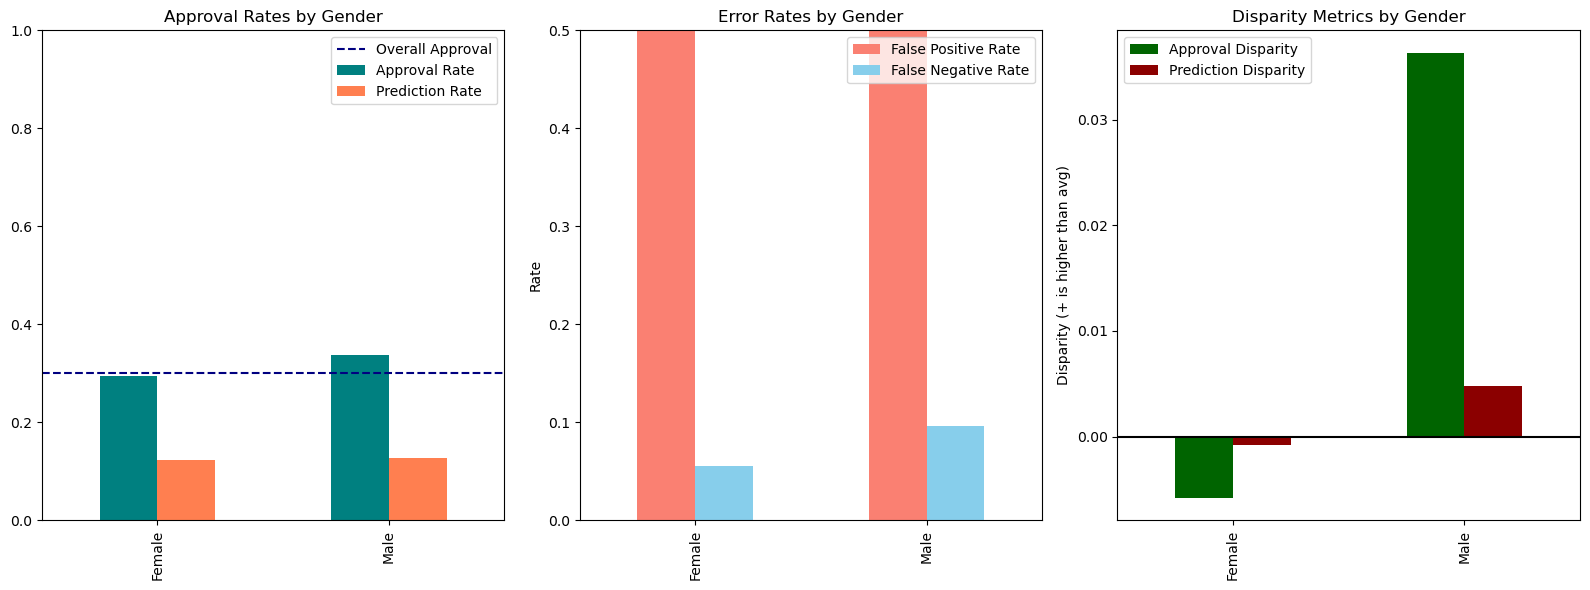


=== BIAS ANALYSIS FOR Gender ===
        Approval Rate  Prediction Rate    FPR    FNR  Count  \
Female          0.294            0.122  0.719  0.055  690.0   
Male            0.336            0.127  0.811  0.096  110.0   

        Approval Disparity  Prediction Disparity  
Female              -0.006                -0.001  
Male                 0.036                 0.005  


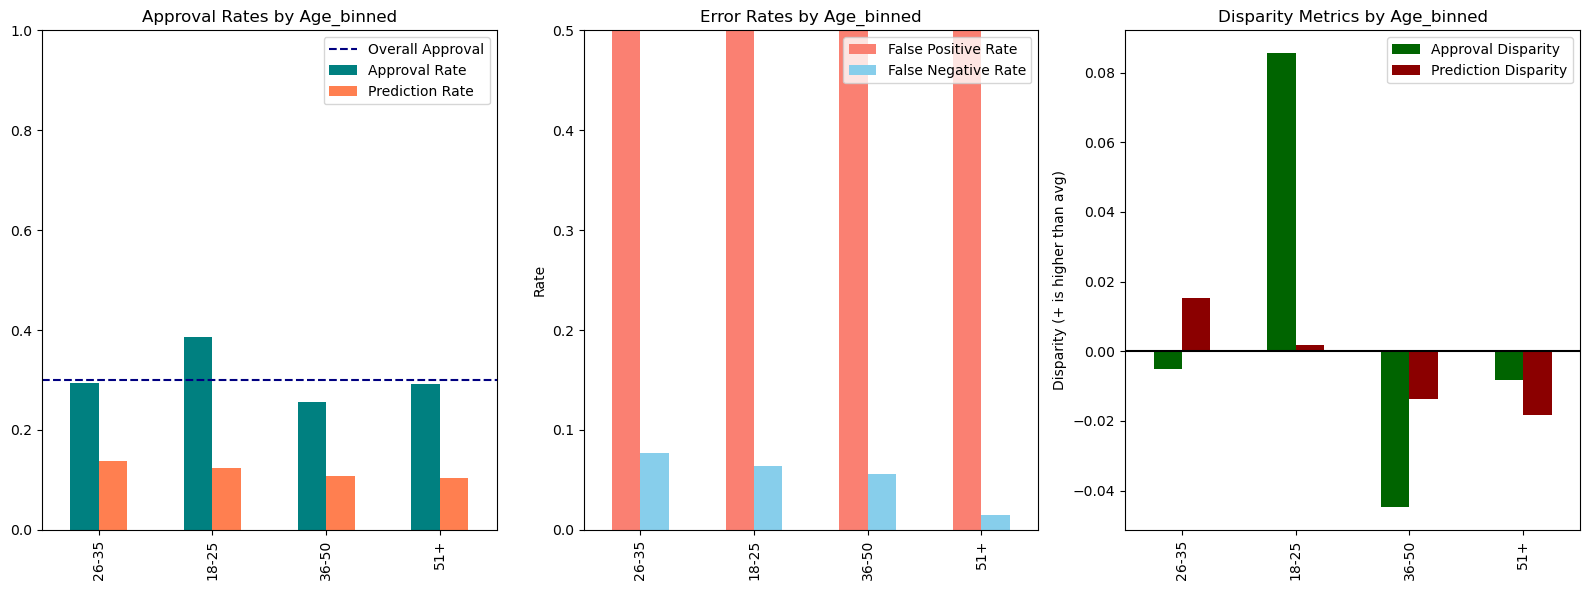


=== BIAS ANALYSIS FOR Age_binned ===
       Approval Rate  Prediction Rate    FPR    FNR  Count  \
26-35          0.295            0.138  0.717  0.077  312.0   
18-25          0.386            0.124  0.780  0.064  153.0   
36-50          0.255            0.109  0.738  0.056  239.0   
51+            0.292            0.104  0.679  0.015   96.0   

       Approval Disparity  Prediction Disparity  
26-35              -0.005                 0.015  
18-25               0.086                 0.002  
36-50              -0.045                -0.014  
51+                -0.008                -0.018  

=== STATISTICAL PARITY FOR Gender ===
                Statistical Parity Difference  Approval Rate Ratio  \
Female vs Male                          0.006                1.143   

                Error Rate Ratio  
Female vs Male             1.127  

=== STATISTICAL PARITY FOR Age_binned ===
                Statistical Parity Difference  Approval Rate Ratio  \
26-35 vs 18-25                        

In [4]:
def run_bias_analysis(data_path="german_credit_data.csv"):
    """Run the full bias analysis pipeline"""
    try:
        # Initialize preprocessor
        print("Loading and preprocessing data...")
        preprocessor = CreditDataPreprocessor(data_path)
        print(f"Data loaded with {len(preprocessor.df)} records")
        
        # Select features for modeling
        features = ['Amount', 'Age', 'Gender', 'Duration', 'InstallmentRate', 
                   'CreditHistory', 'Purpose', 'Savings']
        
        # Get encoded features
        X_encoded = preprocessor.get_encoded_features(features)
        print(f"Training model with {X_encoded.shape[1]} features")
        
        # Train model
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_encoded, preprocessor.y_train)
        
        # Print model summary
        y_pred = model.predict(X_encoded)
        print("\n=== MODEL PERFORMANCE ===")
        print(classification_report(preprocessor.y_train, y_pred))
        
        # Initialize bias detector
        detector = BiasDetector(preprocessor)
        
        # Run bias analysis
        print("\nPerforming bias analysis...")
        results = detector.predict_and_analyze(model, X_encoded)
        
        # Visualize results
        detector.plot_bias_results()
        
        # Calculate statistical parity
        parity_metrics = detector.calculate_statistical_parity()
        
        return preprocessor, model, detector
        
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()
        if 'preprocessor' in locals():
            print("Available columns in data:", preprocessor.df.columns.tolist())
            
# If running as main script
if __name__ == "__main__":
    preprocessor, model, detector = run_bias_analysis()

### Classification Report

- High false negatives for Class 0: Only catches 27% of good applicants
- Over-prediction of defaults: 94% recall for defaults suggests aggressive risk-aversion
- Accuracy is misleading: 74% looks decent but masks poor non-default detection

### Gender Bias Analysis

- Both genders under-approved: Model approves only ~12% vs actual 29-34%
- Male applicants: Higher false denials (FPR 81.1% vs 71.9%), but slightly better approval rates (+3.6% disparity)
- Statistical parity: Minimal difference (0.006), but error rates favor females (1.13× lower)


### Age Group Bias Analysis

- Young applicants (18-25): Highest actual approval (38.6%) but still under-predicted (12.4%). Highest false denials (FPR 78%).
- Older applicants (51+): Lowest model approval (10.4%). Best FNR (1.5%) - model is most accurate here.
- Statistical parity: 26-35 group is reference point; 18-25 has 1.3× higher approval ratio

### Critical Risks Identified

Overly Conservative Model:
- Approves only ~12% vs actual 25-38% approval rates
- Extreme false denial rates (FPR 67-81%)

Age Disparities:
- Young applicants face highest false denials
- Seniors get fewest approvals but most accurate decisions

Gender Paradox:
- Males have higher approval disparity (+3.6%) but worse FPR (81.1%)
- Females face lower FPR but greater under-approval

## Conclusion

1. Conservative Bias
- The model approves only 12% of applicants vs. the actual 25-38% approval rate
- False denial rates (FPR) exceed 70% for all groups

2. Demographic Disparities
- 18-25 year-olds have highest approval disparity (+8.6% vs. avg)
- Women	1.13× have lower error rates than men, but under-approved
- Seniors (51+) have lowest approval rate (10.4%) but most accurate decisions

### Model Limitations
- Poor recall for non-defaults (27%) indicates missed opportunities
- Heavy reliance on default prediction (94% recall for defaults)

### Recommendations

1. Immediate Actions
- Recalibrate decision thresholds to reduce false denials
- Implement fairness constraints (e.g., Demographic Parity)

2. Medium-Term
- Add alternative data sources (e.g., cash flow history)
- Develop group-specific models for high-disparity segments

3. Long-Term
- Establish bias monitoring dashboard
- Formalize ethics review process for model updates

### Lessons Learned

1. Accuracy ≠ Fairness: A 74% accurate model can still be discriminatory
2. Context Matters: Actual approval rates revealed model over-correction for risk
3. Transparency is Critical: Detailed bias analysis enabled targeted improvements

### Next Steps
                                 
1. Prioritize model recalibration for 18-25 year-olds
2. Pilot fairness-aware algorithms with 2023 Q4 data